In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, SeparableConv2D, MaxPooling2D, Add, GlobalAveragePooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split

# Credits

Implementation based from: https://github.com/omar178/Emotion-recognition#p4

#Dataset

Source: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/fer2013.csv')

# convert pixels to original image size (48x48) and resize to (128, 128)
pixels = dataset['pixels'].tolist()
faces = []
for sequence in pixels:
  face = []
  values = sequence.split(' ')
  for value in values:
    face.append(value)
  face = np.array(face).reshape(48, 48)
  face = cv2.resize(face.astype('uint8'), (128, 128))
  faces.append(face.astype('float32'))
faces = np.expand_dims(faces, -1)

# convert emotion value to 1D vector
emotion = dataset['emotion'].tolist()
emotions = []
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
expression = [np.array([1, 0, 0, 0, 0, 0, 0]), np.array([0, 1, 0, 0, 0, 0, 0]),
              np.array([0, 0, 1, 0, 0, 0, 0]), np.array([0, 0, 0, 1, 0, 0, 0]),
              np.array([0 ,0 ,0 ,0, 1, 0 ,0]), np.array([0, 0, 0, 0, 0, 1, 0]),
              np.array([0, 0, 0, 0, 0, 0, 1])]
for value in emotion:
  emotions.append(expression[value])
emotions = np.array(emotions)

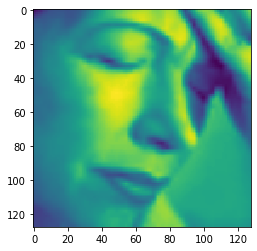

[0 0 0 0 1 0 0]


In [0]:
plt.imshow(np.squeeze(faces[12345]))
plt.show()
print(emotions[12345])

# XCeption CNN

Source: https://arxiv.org/pdf/1610.02357.pdf

We dropped the middle flow and only use entry + exit flow

In [0]:
def XCeption(input):
  out = input
  for i in range(2):
    out = Conv2D(filters=8, kernel_size=3, padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

  for filter in [16, 32, 64, 128]:
    old = Conv2D(filters=filter, kernel_size=1, strides=2, padding='same')(out)
    old = BatchNormalization()(old)

    for i in range(2):
      out = SeparableConv2D(filters=filter, kernel_size=3, padding='same')(out)
      out = BatchNormalization()(out)
      if i == 0:
        out = Activation('relu')(out)

    out = MaxPooling2D(pool_size=3,  strides=2, padding='same')(out)
    out = Add()([out, old])

  out = Conv2D(filters=7, kernel_size=3, padding='same')(out)
  out = GlobalAveragePooling2D()(out)
  out = Activation('softmax')(out)

  return Model(input, out)

# Train/Testing

In [0]:
# split dataset in a randomize manner so there's variation between trainings
x_train, x_test, y_train, y_test = train_test_split(faces, emotions, shuffle=True)

input = Input((128, 128, 1))
cnn = XCeption(input)
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# cnn.summary()
cnn.load_weights('/content/drive/My Drive/emotion_recognition.h5')

#mc = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/project_weights3/weight{epoch:04d}.h5', save_weights_only=True)

#generator = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
#cnn.fit_generator(generator.flow(x_train, y_train), steps_per_epoch=(len(x_train)/32), epochs=200, callbacks=[mc], validation_data=(x_test, y_test))

In [0]:
print(np.shape(faces[12345]))
img = faces[12345]
img = np.expand_dims(img, axis=0)
result = cnn.predict(img)[0]
print(result)
print(np.max(result))
print(np.argmax(result))
print(expression[4])

(128, 128, 1)
[3.0984634e-03 4.5305504e-05 7.3009431e-02 2.3341244e-03 9.1433972e-01
 1.8355870e-04 6.9894036e-03]
0.9143397
4
[0 0 0 0 1 0 0]
